# Import Libraries

In [1]:
import math
import pandas as pd
import numpy as np
from numpy import random as rnd

from tsad.evaluating.evaluating import evaluating #F1 score
from detecta import detect_cusum #CUMSUM

import matplotlib.pyplot as plt

import requests
from io import StringIO


import sys
sys.path.append(r'/home/gishb/PycharmProjects/Fedot_Industrial_old/Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq

from scipy.signal import savgol_filter

# Dataset

In [2]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

In [10]:
df = df_expirement()
df = df[df[df.columns[0]] == 'xxxAA564G'] #xxxAA684G

df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
df = df[df['unitless'].notna()]
df = df[df['uR/h'].notna()]
df = df.drop(axis=1, labels=(df.columns[0])) \
    .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8754 entries, 1970-01-01 00:00:00 to 1970-01-01 02:25:53
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   m              8754 non-null   float64
 1   v/v            8754 non-null   float64
 2   v/v.1          8754 non-null   float64
 3   uR/h           8754 non-null   float64
 4   v/v.2          0 non-null      float64
 5   v/v.3          0 non-null      float64
 6   v/v.4          0 non-null      float64
 7   mD             0 non-null      float64
 8   v/v.5          0 non-null      float64
 9   unitless       8754 non-null   float64
 10  unitless.1     8754 non-null   float64
 11  m/hr           8754 non-null   float64
 12  ohmm           8754 non-null   float64
 13  ohmm.1         8754 non-null   float64
 14  ohmm.2         8754 non-null   float64
 15  ohmm.3         8754 non-null   float64
 16  ohmm.4         0 non-null      float64
 17  ohmm.5         8

In [12]:
#Create new columns for CPd and time
df['change_points'] = [1 if df['unitless'][i] !=  df['unitless'][i+1] else 0 for i in range(len(df)-1)] + [0]
df['time'] = np.arange(0, len(df)*1, 1).astype('datetime64[s]')
df = df.set_index('time')

# Breef look at data

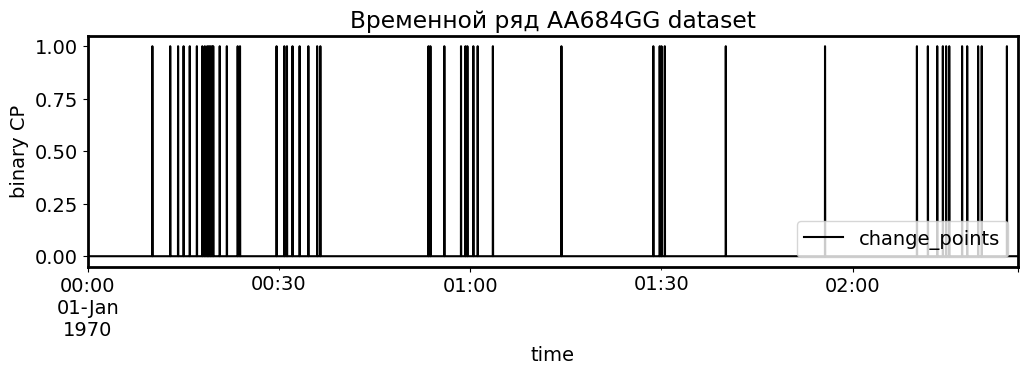

 Number CP: 52
 len data: 8754


In [9]:
df.change_points.plot(figsize=(12,3), color='black')
plt.legend(loc="lower right",)
plt.title('Временной ряд AA684GG dataset')
plt.ylabel('binary CP')
plt.show()
print(f' Number CP: {df[df["change_points"] == 1].count()[0]}')
print(f' len data: {df.count()[0]}')

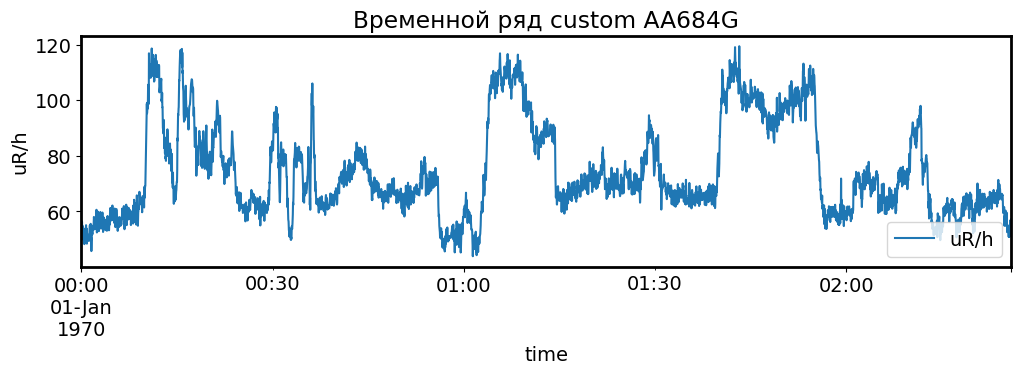

In [6]:
df['uR/h'].plot(figsize=(12,3))
plt.legend(loc="lower right")
plt.title('Временной ряд custom AA684G')
plt.ylabel('uR/h')
plt.show()

# Define filters & cumsumm & TSAD metric

In [7]:
def filter_butterworth(ts, freq): #list, int(1)
    '''
        Just butterworh filter
    '''
    fc_opt = optcutfreq(ts, freq=freq, show=False)

    C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
    b, a = butter(2, (fc_opt/C)/(freq/2))
    dispf = filtfilt(b, a, ts)
    aaccBW =  np.diff(dispf, 2)*fc_opt*fc_opt
    return aaccBW

def cumsum(x, quantile_=0.99):
    '''
        Just CUMSUM filter
    '''
    quantile_99 = np.quantile(x, quantile_)
    new_x = [g if abs(g) < quantile_99 else quantile_99*1.5 for g in x]
    ending, start, alarm, cumsum = detect_cusum(new_x, np.mean(new_x)+np.std(new_x)*3, np.std(new_x), True, False)
    return ending, start, alarm, cumsum 

def filter_Savgol(x, window_length):
    '''
        Savitzky-Golay filter from scipy
    '''
    aaccSG = savgol_filter(x, window_length, 3, mode='nearest')
    return np.array(aaccSG)

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

def normalization_linear(x):
    return (x-min(x))/(max(x)-min(x))

# Workflow: 1 stage - apply filter 

In [8]:
time_series = normalization_linear(np.array(df['uR/h']))
# ts_butterworth = filter_butterworth(time_series, 1)
ts_savgol = normalization_linear(filter_Savgol(time_series, 60))
print(f'time series.shape: {time_series.shape}')

time series.shape: (8754,)


# Workflow: 2 stage - search and set hyperparameters

In [9]:
window_length = WindowSizeSelection(time_series = list(time_series),
                                       wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]

In [10]:
ts_window_length = WindowSizeSelection(time_series = time_series, wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]
trajectory_window_length = WindowSizeSelection(time_series = time_series[:ts_window_length], window_max = ts_window_length,  wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]
print(f'ts_window_length = {ts_window_length}')
print(f'trajectory_window_length = {trajectory_window_length}')

ts_window_length = 57
trajectory_window_length = 20


# Workflow: 3 stage -  define SST model

In [11]:
model = SingularSpectrumTransformation(time_series=time_series, quantile_rate=0.95,
                                       trajectory_window_length=trajectory_window_length,
                                       ts_window_length=ts_window_length, lag=int(ts_window_length/2), view=False)

# Workflow: 4 stage - run SST model and apply CUMSUM

In [12]:
score = model.score_offline(dynamic_mode=True)
score = cumsum(score)
df['predicted_cp'] = [1 if i in score[-2] else 0 for i in range(len(df))]

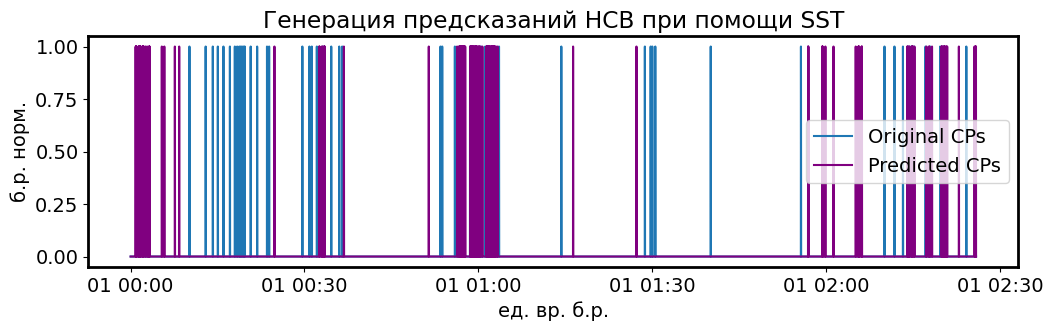

In [13]:
plt.figure(figsize=(12,3))
plt.plot(df['change_points'], label='Original CPs')
plt.plot(df['predicted_cp'],label='Predicted CPs', color='Purple')
plt.legend(loc="center right")
plt.title('Генерация предсказаний НСВ при помощи SST')
plt.xlabel('ед. вр. б.р.')
plt.ylabel('б.р. норм.')
plt.show()

# Workflow: 5 stage apply queue filter

In [14]:
def queue(queue_window=10, time_series=None):
    queue = [0]*queue_window
    filtered_score = []
    for i in range(len(time_series)):
        value = time_series[i]
        if max(queue) != 0: #Вариант при котором CPs уже в очереди
            filtered_score.append(0)
            queue.pop(0)
            queue.append(0)
        else: # В очереди нет CPs
            filtered_score.append(value)
            queue.pop(0)
            queue.append(value)
    return filtered_score

In [15]:
SST_queue_CPs = queue(queue_window=ts_window_length, time_series=list(df['predicted_cp']))
df['SST_queue_CPs'] = SST_queue_CPs

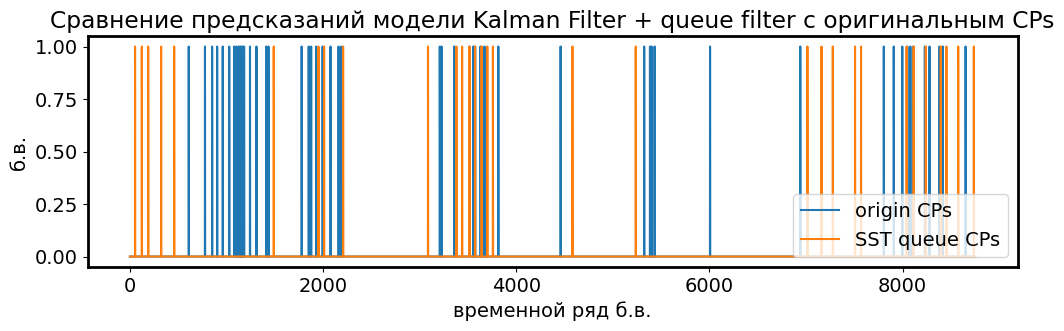

In [16]:
plt.figure(figsize=(12,3))
plt.plot(list(df['change_points']), label='origin CPs')
plt.plot(SST_queue_CPs, label='SST queue CPs')
plt.legend(loc="lower right")
plt.title('Сравнение предсказаний модели Kalman Filter + queue filter с оригинальным CPs')
plt.xlabel('временной ряд б.в.')
plt.ylabel('б.в.')
plt.show()

# Workflow 6: create report

In [17]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

In [18]:
%%capture --no-display
tsad_average_results = tsad_average(df.SST_queue_CPs, df.change_points)

In [19]:
%%capture --no-display
tsad_nab_results = tsad_nab(df.SST_queue_CPs, df.change_points)

In [20]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,2.64
LowFP,-0.44
LowFN,4.32
Time_Delta,0 days 00:00:14.750000
Missed_CP,48
FPs,27
True_Anomalies_Count,52
precision,0.129032
recall,0.076923
F1,0.096386
